In [132]:
import pandas as pd
from IPython.display import display, HTML
%load_ext autoreload
%autoreload 2

import importlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
csv_file = open("uaScoresDataFrame.csv")
scores = pd.read_csv(csv_file)
scores = scores.drop('id', axis=1)
scores = scores.drop('Venture Capital', axis=1)

In [134]:
def check_zero(dataset):
    invalid_rows = []
    for element in dataset.columns.tolist():
        invalid = dataset[dataset[element] == 0.0]
        invalid_rows.append(invalid[['UA_Name','UA_Country']])
    df = pd.concat(invalid_rows).reset_index(drop=True).value_counts()
    return df
results = check_zero(scores).to_frame().reset_index().rename(columns={0:"number"})
print(results)

                       UA_Name               UA_Country  number
0                      Andorra                  Andorra       6
1                    Gibraltar                Gibraltar       5
2                      Managua                Nicaragua       3
3                     Tashkent               Uzbekistan       3
4                  Belize City                   Belize       3
5                       Panama                   Panama       3
6                    Palo Alto               California       2
7                       La Paz                  Bolivia       2
8                     Portland                    Maine       2
9                       Havana                     Cuba       2
10                     Fukuoka                    Japan       2
11                    San Juan              Puerto Rico       2
12                     Bozeman                  Montana       2
13                   Baltimore                 Maryland       2
14                    Valletta          

In [135]:
scores = scores[(scores != 0).all(1)]

In [136]:
weights_data = {
    'Housing' : 1.5,
    'Cost of Living' : 1.5,
    'Startups' : 0.5,
    'Business Freedom' : 0.8,
    'Safety' : 1.5,
    'Healthcare' : 1.5,
    'Education' : 0.5,
    'Travel Connectivity' : 1.5,
}

weights_vector = pd.Series(0.0, index=scores.columns[3:-1])
for i in range(len(weights_vector)):
    row_name = weights_vector.index[i]
    weights_vector[i] = weights_data.get(row_name, 1)

In [137]:
summable_values = list(scores)
if 'Naive Sum' in summable_values:
    summable_values.remove('Naive Sum')
weighted_scores = scores.copy()
weighted_scores = weighted_scores * weights_vector
scores['Naive Sum'] = weighted_scores[summable_values].sum(numeric_only=True, axis=1)

In [138]:
# scores['Naive Sum']
# better, worse

midpoint = scores['Naive Sum'].quantile()
scores['Label'] = ''
scores.loc[scores['Naive Sum'] < midpoint, 'Label'] = 'worse'
scores.loc[scores['Naive Sum'] >= midpoint, 'Label'] = 'better'

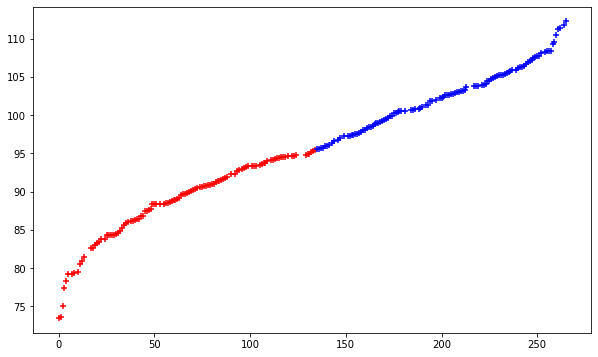

In [139]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
vals = scores['Naive Sum'].sort_values()
colors = np.where(vals >= midpoint, 'b', 'r')
ax.scatter(scores.index, vals, c=colors, marker='+')

In [140]:
from Modules.dataprocessing import ProcessingData
ProcessingData.normalize(scores)
a, b = ProcessingData.prepare_data(scores)

preview_table = pd.concat([a.head(), b.head()])

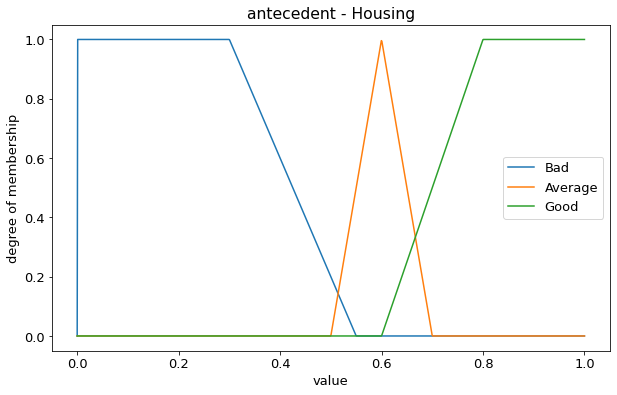

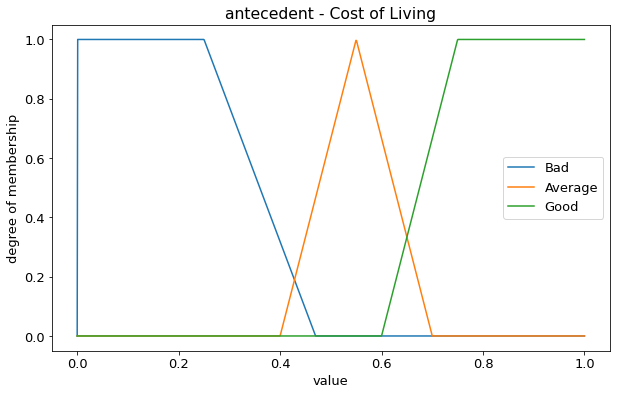

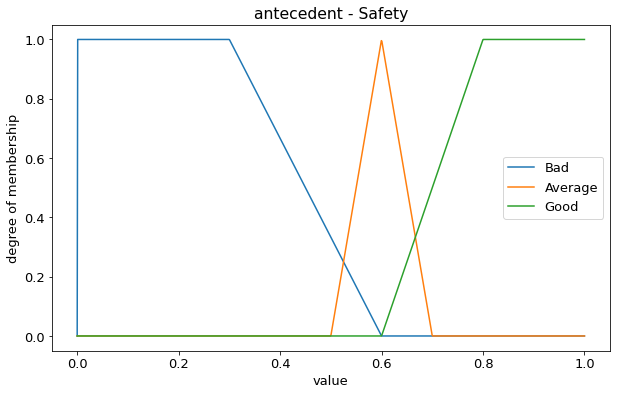

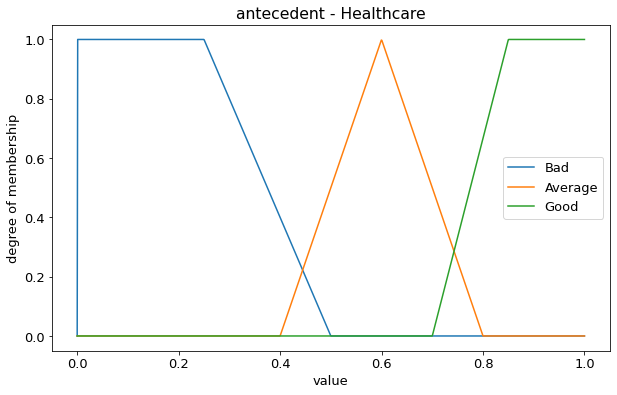

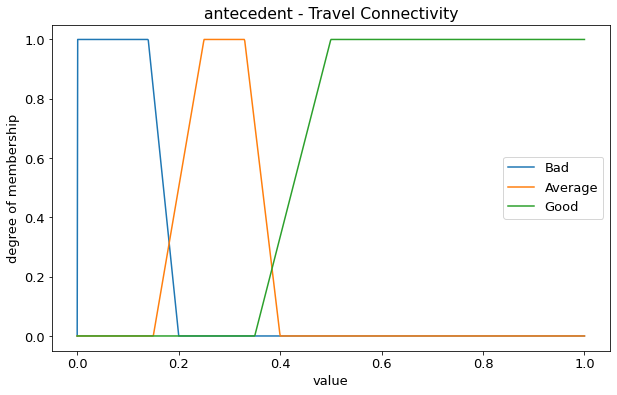

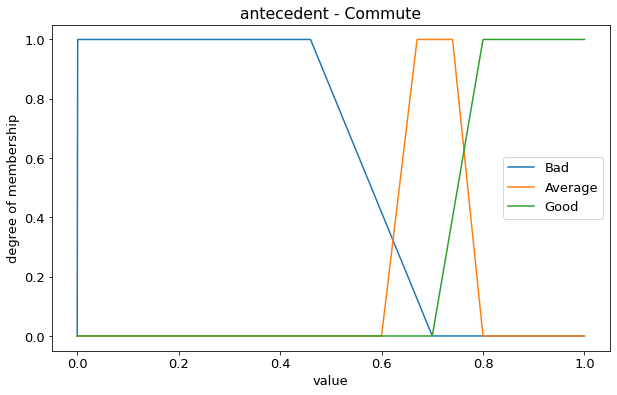

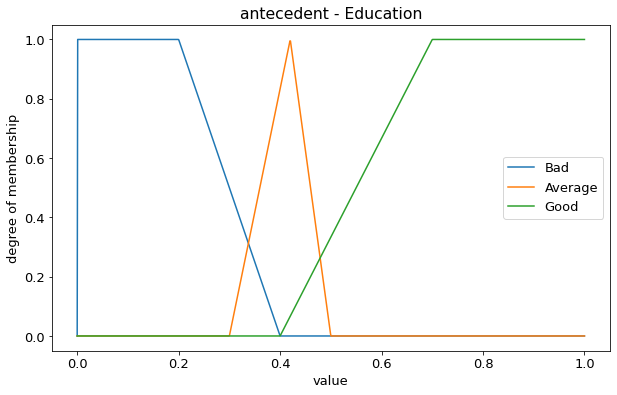

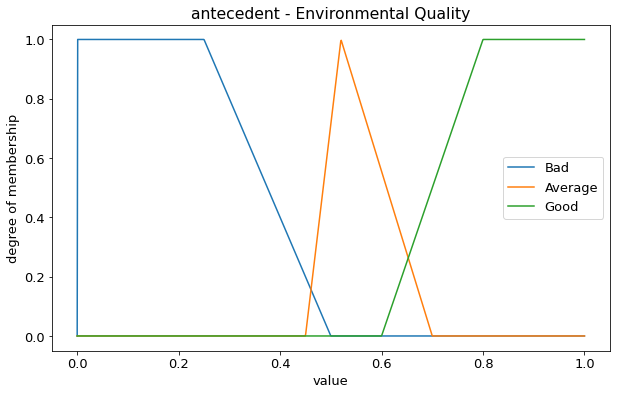

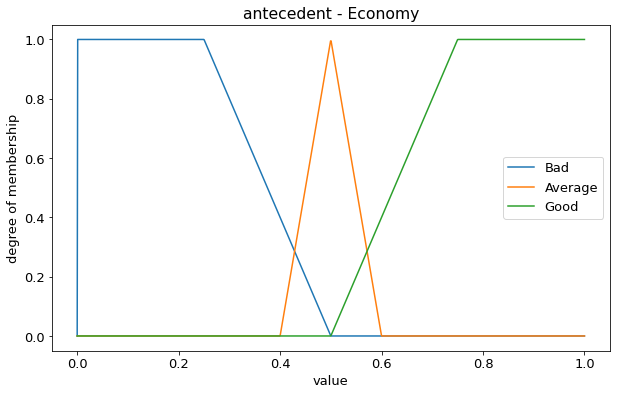

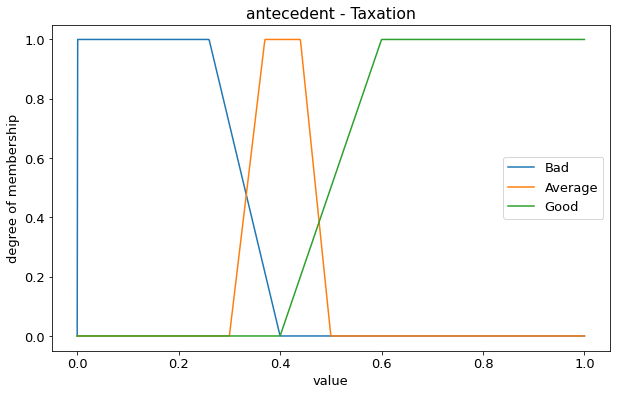

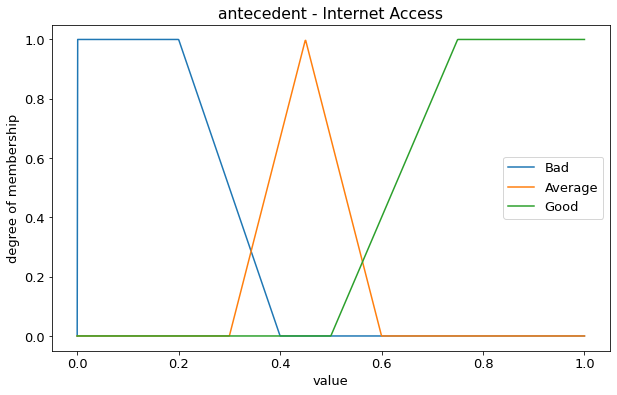

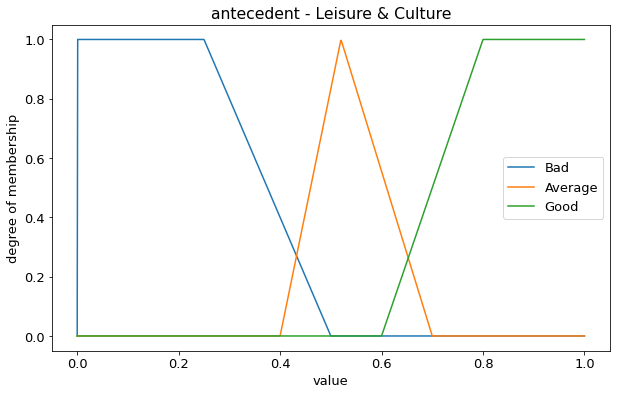

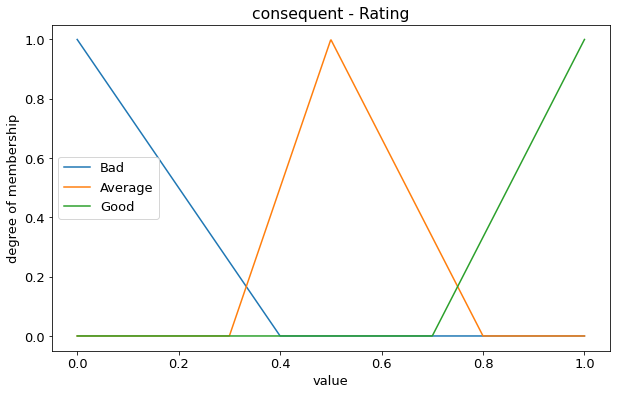

FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = fom, THRESHOLD = 70


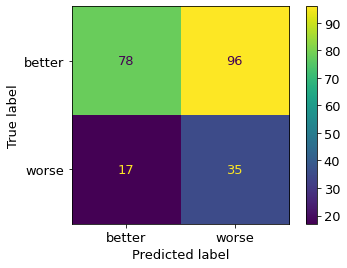

 > accuracy: 77.0%
 > recall: 69.0%
 > specificity: 85.0%
 > precision: 82.1%
----------------------------------------------------------------------------------
FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = mom, THRESHOLD = 70


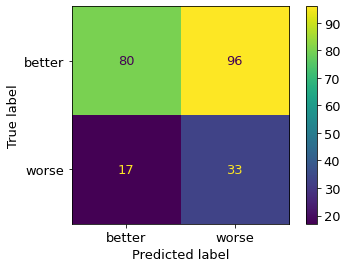

 > accuracy: 77.9%
 > recall: 70.8%
 > specificity: 85.0%
 > precision: 82.5%
----------------------------------------------------------------------------------
FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = lom, THRESHOLD = 70


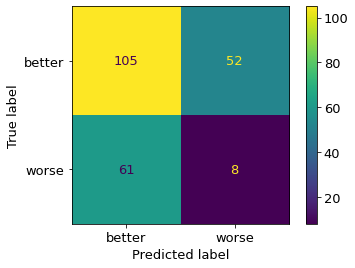

 > accuracy: 69.5%
 > recall: 92.9%
 > specificity: 46.0%
 > precision: 63.3%
----------------------------------------------------------------------------------


C:\Users\janka\OneDrive\Dokumenty\GitHub\city_quality_of_life_classifier\Modules\defuzzification_methods.py:28: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum(x * fx) / np.sum(fx)
C:\Users\janka\OneDrive\Dokumenty\GitHub\city_quality_of_life_classifier\Modules\defuzzification_methods.py:28: RuntimeWarning: invalid value encountered in long_scalars
  return np.sum(x * fx) / np.sum(fx)


FOR NORM = ZadehNorm, DEFUZZIFICATION METHOD = centroid, THRESHOLD = 70


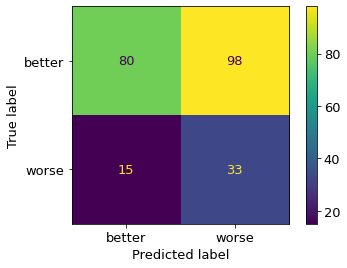

 > accuracy: 78.8%
 > recall: 70.8%
 > specificity: 86.7%
 > precision: 84.2%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = fom, THRESHOLD = 70


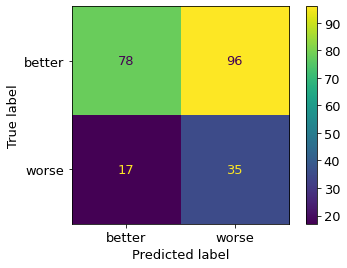

 > accuracy: 77.0%
 > recall: 69.0%
 > specificity: 85.0%
 > precision: 82.1%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = mom, THRESHOLD = 70


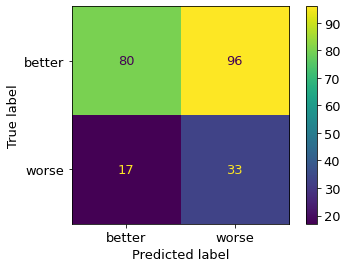

 > accuracy: 77.9%
 > recall: 70.8%
 > specificity: 85.0%
 > precision: 82.5%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = lom, THRESHOLD = 70


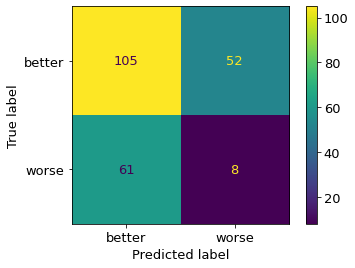

 > accuracy: 69.5%
 > recall: 92.9%
 > specificity: 46.0%
 > precision: 63.3%
----------------------------------------------------------------------------------
FOR NORM = ExtendedMangerNorm, DEFUZZIFICATION METHOD = centroid, THRESHOLD = 70


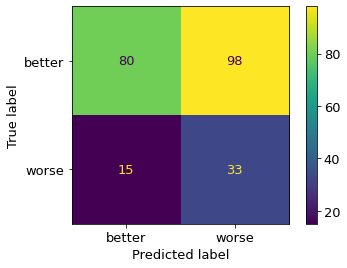

 > accuracy: 78.8%
 > recall: 70.8%
 > specificity: 86.7%
 > precision: 84.2%
----------------------------------------------------------------------------------


In [141]:
from itertools import product
import Modules.fuzzytesting as test
from Modules.fuzzytesting import FuzzyTest
importlib.reload(test)
import Modules.fuzzysys as fsys
from Modules.norms import ZadehNorm
from Modules.membership_functions import TriangularFunction, TrapezoidalFunction
importlib.reload(fsys)
import Modules.rule as rule
from Modules.rule import RuleCondition as R
importlib.reload(rule)

from Modules.norms import ZadehNorm, ExtendedMangerNorm

Bad = 'Bad'
Average = 'Average'
Good = 'Good'

fuzzy = fsys.FuzzySystem()
fuzzy.add_antecedent('Housing', Bad, TrapezoidalFunction(0, 0, 0.3, 0.55))
fuzzy.add_antecedent('Housing', Average, TriangularFunction(0.5, 0.6, 0.7))
fuzzy.add_antecedent('Housing', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Cost of Living', Bad, TrapezoidalFunction(0, 0, 0.25, 0.47))
fuzzy.add_antecedent('Cost of Living', Average, TriangularFunction(0.4, 0.55, 0.7))
fuzzy.add_antecedent('Cost of Living', Good, TrapezoidalFunction(0.6, 0.75, 1, 1))

fuzzy.add_antecedent('Safety', Bad, TrapezoidalFunction(0, 0, 0.3, 0.6))
fuzzy.add_antecedent('Safety', Average, TriangularFunction(0.5, 0.6, 0.7))
fuzzy.add_antecedent('Safety', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Healthcare', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Healthcare', Average, TriangularFunction(0.4, 0.6, 0.8))
fuzzy.add_antecedent('Healthcare', Good, TrapezoidalFunction(0.7, 0.85, 1, 1))

fuzzy.add_antecedent('Travel Connectivity', Bad, TrapezoidalFunction(0, 0, 0.14, 0.2))
fuzzy.add_antecedent('Travel Connectivity', Average, TrapezoidalFunction(0.15, 0.25, 0.33, 0.4))
fuzzy.add_antecedent('Travel Connectivity', Good, TrapezoidalFunction(0.35, 0.5, 1, 1))

fuzzy.add_antecedent('Commute', Bad, TrapezoidalFunction(0, 0, 0.46, 0.7))
fuzzy.add_antecedent('Commute', Average, TrapezoidalFunction(0.6, 0.67, 0.74, 0.8))
fuzzy.add_antecedent('Commute', Good, TrapezoidalFunction(0.7, 0.8, 1, 1))

fuzzy.add_antecedent('Education', Bad, TrapezoidalFunction(0, 0, 0.2, 0.4))
fuzzy.add_antecedent('Education', Average, TriangularFunction(0.3, 0.42, 0.5))
fuzzy.add_antecedent('Education', Good, TrapezoidalFunction(0.4, 0.7, 1, 1))

fuzzy.add_antecedent('Environmental Quality', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Environmental Quality', Average, TriangularFunction(0.45, 0.52, 0.7))
fuzzy.add_antecedent('Environmental Quality', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_antecedent('Economy', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Economy', Average, TriangularFunction(0.4, 0.5, 0.6))
fuzzy.add_antecedent('Economy', Good, TrapezoidalFunction(0.5, 0.75, 1, 1))

fuzzy.add_antecedent('Taxation', Bad, TrapezoidalFunction(0, 0, 0.26, 0.4))
fuzzy.add_antecedent('Taxation', Average, TrapezoidalFunction(0.3, 0.37, 0.44, 0.5))
fuzzy.add_antecedent('Taxation', Good, TrapezoidalFunction(0.4, 0.6, 1, 1))

fuzzy.add_antecedent('Internet Access', Bad, TrapezoidalFunction(0, 0, 0.2, 0.4))
fuzzy.add_antecedent('Internet Access', Average, TriangularFunction(0.3, 0.45, 0.6))
fuzzy.add_antecedent('Internet Access', Good, TrapezoidalFunction(0.5, 0.75, 1, 1))

fuzzy.add_antecedent('Leisure & Culture', Bad, TrapezoidalFunction(0, 0, 0.25, 0.5))
fuzzy.add_antecedent('Leisure & Culture', Average, TriangularFunction(0.4, 0.52, 0.7))
fuzzy.add_antecedent('Leisure & Culture', Good, TrapezoidalFunction(0.6, 0.8, 1, 1))

fuzzy.add_rule((R('Housing', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Healthcare', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Housing', Good) & R('Safety', Good) & R('Healthcare', Good)) | (R('Housing', Good) & R('Safety', Good) & R('Travel Connectivity', Good)) | (R('Housing', Good) & R('Healthcare', Good) & R('Travel Connectivity', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Travel Connectivity', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Housing', Good) & R('Cost of Living', Good) & R('Safety', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Safety', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Healthcare', Good) & R('Cost of Living', Good) & R('Travel Connectivity', Good)) | (R('Travel Connectivity', Good) & R('Healthcare', Good) & R('Safety', Good)), Good)
fuzzy.add_rule((R('Housing', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Healthcare', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Housing', Average) & R('Safety', Average) & R('Healthcare', Average)) | (R('Housing', Average) & R('Safety', Average) & R('Travel Connectivity', Average)) | (R('Housing', Average) & R('Healthcare', Average) & R('Travel Connectivity', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Travel Connectivity', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Housing', Average) & R('Cost of Living', Average) & R('Safety', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Safety', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Healthcare', Average) & R('Cost of Living', Average) & R('Travel Connectivity', Average)) | (R('Travel Connectivity', Average) & R('Healthcare', Average) & R('Safety', Average)), Average)
fuzzy.add_rule((R('Housing', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Healthcare', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Housing', Bad) & R('Safety', Bad) & R('Healthcare', Bad)) | (R('Housing', Bad) & R('Safety', Bad) & R('Travel Connectivity', Bad)) | (R('Housing', Bad) & R('Healthcare', Bad) & R('Travel Connectivity', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Travel Connectivity', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Housing', Bad) & R('Cost of Living', Bad) & R('Safety', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Safety', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Healthcare', Bad) & R('Cost of Living', Bad) & R('Travel Connectivity', Bad)) | (R('Travel Connectivity', Bad) & R('Healthcare', Bad) & R('Safety', Bad)), Bad)
fuzzy.add_rule(((((R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & R('Safety', Good) & ~R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & R('Healthcare', Good) & ~R('Travel Connectivity', Good)) | (~R('Housing', Good) & ~R('Cost of Living', Good) & ~R('Safety', Good) & ~R('Healthcare', Good) & R('Travel Connectivity', Good))) & ((R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Leisure & Culture', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Internet Access', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Leisure & Culture', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Internet Access', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) & (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Leisure & Culture', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Internet Access', Good) & R('Economy', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Internet Access', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Leisure & Culture', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Internet Access', Good) & R('Taxation', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Leisure & Culture', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Internet Access', Good)) | (R('Commute', Good) & R('Education', Good) & R('Environmental Quality', Good) & R('Economy', Good) & R('Taxation', Good))))), Good)
fuzzy.add_rule(((((R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & R('Safety', Average) & ~R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & R('Healthcare', Average) & ~R('Travel Connectivity', Average)) | (~R('Housing', Average) & ~R('Cost of Living', Average) & ~R('Safety', Average) & ~R('Healthcare', Average) & R('Travel Connectivity', Average))) & ((R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Leisure & Culture', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Internet Access', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Leisure & Culture', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Internet Access', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) & (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Leisure & Culture', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Internet Access', Average) & R('Economy', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Internet Access', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Leisure & Culture', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Internet Access', Average) & R('Taxation', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Leisure & Culture', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Internet Access', Average)) | (R('Commute', Average) & R('Education', Average) & R('Environmental Quality', Average) & R('Economy', Average) & R('Taxation', Average))))), Average)
fuzzy.add_rule(((((R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & R('Safety', Bad) & ~R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & R('Healthcare', Bad) & ~R('Travel Connectivity', Bad)) | (~R('Housing', Bad) & ~R('Cost of Living', Bad) & ~R('Safety', Bad) & ~R('Healthcare', Bad) & R('Travel Connectivity', Bad))) & ((R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Leisure & Culture', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Internet Access', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Leisure & Culture', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Internet Access', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) & (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Leisure & Culture', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Internet Access', Bad) & R('Economy', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Internet Access', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Leisure & Culture', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Internet Access', Bad) & R('Taxation', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Leisure & Culture', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Internet Access', Bad)) | (R('Commute', Bad) & R('Education', Bad) & R('Environmental Quality', Bad) & R('Economy', Bad) & R('Taxation', Bad))))), Bad)

fuzzy.add_consequent(Bad, TriangularFunction(0, 0, 0.4))
fuzzy.add_consequent(Average, TriangularFunction(0.3, 0.5, 0.8))
fuzzy.add_consequent(Good, TriangularFunction(0.7, 1, 1))

fuzzy.display_antecedents()
fuzzy.display_consequents()

for (norm, defuzz_method) in product([ZadehNorm, ExtendedMangerNorm], ['fom', 'mom', 'lom', 'centroid']):
    fuzzy_test = FuzzyTest(norm=norm(), defuzzification_method=defuzz_method)
    fuzzy_test.run(fuzzy, pd.concat([a, b]), show_confusion_matrix=True)